In [1]:
import time
plc=0
time.sleep(3000*plc)         #run after 1 houre = 3600 seconds

In [2]:
import os
import glob
import scipy
import random
import bisect
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from preprocess import *                         #ماژول استخراج پنجره ها
from data import *                          #ماژول محلی ورود داده ها
from augment import *                            #ماژول های داده افزایی
from lstm_cnn import *                           #ماژول های داده افزایی با lstm_cnn
import augment
import importlib
importlib.reload(augment)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,recall_score,precision_score
from tensorflow.keras import callbacks
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D,Conv1D,Dropout,MaxPooling1D,MaxPooling2D,Flatten,Dense
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
cwd = os.getcwd() #
fullscrn()

<h1><center><div style="direction:rtl;font-family:B Nazanin">Importing Data</div></center></h1>

In [3]:
import glob
#from glob import glob
cwd = os.getcwd() #
mthd=10
i=1
adrs=('{}/AugEvl/AugEvl{}{}.csv'.format(cwd,i,mthd))   #'_3\*.csv' select base on quality 3,4,5
alldata = []                                                      # List for storing all the data
#print('alldata shape = ', np.shape(alldata))
data = pd.read_csv(adrs)                                     # Load mat file data into data.
data=np.array(data)

In [4]:
np.shape(data)

(248, 486)

In [6]:
data[1]

array([ 1.00000000e+00,  1.41015625e+00,  1.71875000e+00,  2.00195312e+00,
        2.24218750e+00,  2.43359375e+00,  2.57031250e+00,  2.65820312e+00,
        2.70703125e+00,  2.71679688e+00,  2.69140625e+00,  2.62500000e+00,
        2.50585938e+00,  2.33007812e+00,  2.08789062e+00,  1.78906250e+00,
        1.44824219e+00,  1.09472656e+00,  7.63671875e-01,  4.92675781e-01,
        3.12011719e-01,  2.39379883e-01,  2.75390625e-01,  4.02587891e-01,
        5.90820312e-01,  8.01269531e-01,  9.96582031e-01,  1.14843750e+00,
        1.24121094e+00,  1.27441406e+00,  1.26074219e+00,  1.22070312e+00,
        1.17871094e+00,  1.15234375e+00,  1.15136719e+00,  1.17578125e+00,
        1.21777344e+00,  1.26269531e+00,  1.29394531e+00,  1.30175781e+00,
        1.27734375e+00,  1.22070312e+00,  1.13574219e+00,  1.02832031e+00,
        9.04785156e-01,  7.71484375e-01,  6.31347656e-01,  4.85595703e-01,
        3.35937500e-01,  1.85668945e-01,  3.96728516e-02, -9.44824219e-02,
       -2.08740234e-01, -

In [2]:
for i in range (1,18):
    vars()['ecg'+str(i)]=MITBIH(i)
os.chdir(cwd)
clses_lens=np.array([])
i=0                               #جمع آوری داده ها و چاپ تعداد نمونه ی هر کلاس
ecg=np.array(ecg1)
print(1,len(vars()['ecg'+str(1)]), end='\t')
clses_lens=np.append(clses_lens,len(vars()['ecg'+str(1)]))
for i in range (2,18):
    ecg=np.concatenate((ecg,vars()['ecg'+str(i)]),axis=0)
    clses_lens=np.append(clses_lens,len(vars()['ecg'+str(i)]))
    print( i,len(vars()['ecg'+str(i)]), end='\t')

mx_sig=max(clses_lens)

1 283	2 66	3 20	4 135	5 13	6 21	7 133	8 55	9 13	10 10	11 10	12 10	13 11	14 103	15 62	16 10	17 45	

<h2><center><div style="direction:rtl;font-family:B Nazanin">Base Train windows</div></center></h1>

In [25]:
smpl_rte=480                                              # در ماژول ها نیز همین مقدار ثبت شده
i=0
windws=np.array([])
for cls in range (1,18):                                 #ساخت پنجره های داده های آموزش اصلی
    dta=np.array(vars()['ecg'+str(cls)][int(.1*len(vars()['ecg'+str(cls)])):,:]) #انتخاب محدوده ترِین جهت داده افزایی
    vars()['wndws'+str(cls)]=wndwng(dta)                #نرخ نمونه برداری 480 است و شماره کلاس در آخر ردیف نیست
    clm0vlu=np.zeros(len(vars()['wndws'+str(cls)]))
    cls_clm=np.array(clm0vlu)
    cls_clm=np.int16(cls_clm+cls)
    cls_clm=np.transpose([cls_clm])                     # افزودن ستون برچسب (شماره کلاس) به سمت راست پنجره ها
    vars()['wndws'+str(cls)]=np.concatenate((vars()['wndws'+str(cls)],cls_clm),axis=1)   

print("each class and its windows =")
cls_wndws=np.array([])
for cls in range (1,18):                                # آرایه ی تعداد پنجره ی هر کلاس
    wns=len(vars()['wndws'+str(cls)])
    cls_wndws=np.append(cls_wndws,wns)
    print(cls, wns, end='\t')
    
mx_wndws=int(np.max(cls_wndws))                        # حداکثر تعداد پنجره ی موجود بین کلاس ها
print('\n max =', mx_wndws)

each class and its windows =
1 2598	2 788	3 224	4 1564	5 158	6 189	7 1371	8 553	9 114	10 104	11 72	12 107	13 156	14 1014	15 633	16 45	17 450	
 max = 2598


In [26]:
#clses=18                                   #تعیین میزان افزایش نمونه (تولید داده)
#mx_wndws=int(mx_wndws*1.05)  #mx_wndws*0.3  # =classes-1 برای بررسی الگوریتم تعداد کمی کلاس آزمایش شد
mx_wndws=mx_wndws+3           
print(mx_wndws)

2601


<h1><center><div style="direction:rtl;font-family:B Nazanin">Data Augmentation</div></center></h1>

In [34]:
methd=40
sort=-3          #-5=Dis_sam_Cls=qlty1   #-4=var_Dis=qlty2    #-3=DisSm/DisOthr=qlty3    #-2=GDO_papr=qlty4   #-1=invrs_GDO_papr=qlty5  
dp_slct_dstrb=1  #1-sequencial 2-linear 3-beta 4-exponential 5-unfrm
    
for i in range (1,18):                           #تعریف آرایه ی پنجره های کلاس ها
    vars()['ecg_aug'+str(i)+str(methd)]=np.empty((0,smpl_rte+1), float) 
    #vars()['ecg_aug'+str(i)+str(methd)]=np.empty((0,smpl_rte+1), float) 

for i in range (1,18):                           #تعریف آرایه ی پنجره های کلاس ها
    vlum_win=mx_wndws-len(vars()['wndws'+str(i)])#میزان داده افزایی در روش های عمیق (پنجره)
    dif_sig=mx_sig-len(vars()['ecg'+str(i)])     
    ratio=(mx_wndws/mx_sig)/(cls_wndws[i-1]/clses_lens[i-1])
    vlum_sig=int(dif_sig*ratio)                  #میزان داده افزایی در روش های هندسی (سیگنال)
    vars()['ecg_aug'+str(i)+str(methd)]=np.append(vars()['ecg_aug'+str(i)+str(methd)],srtd_data(methd,i,vlum_win,dp_slct_dstrb,sort),axis=0)
    #print('generated data shape for class ', i, ' = ', np.shape(vars()['ecg_aug'+str(i)+str(methd)]))
    print('generated data shape for class ', i, ' = ', np.shape(vars()['ecg_aug'+str(i)+str(methd)]),'\n\n')

generated data shape for class  1  =  (3, 481) 


generated data shape for class  2  =  (1813, 481) 


generated data shape for class  3  =  (2377, 481) 


generated data shape for class  4  =  (1037, 481) 


generated data shape for class  5  =  (2443, 481) 


generated data shape for class  6  =  (2412, 481) 


generated data shape for class  7  =  (1230, 481) 


generated data shape for class  8  =  (2048, 481) 


generated data shape for class  9  =  (2487, 481) 


generated data shape for class  10  =  (2497, 481) 


generated data shape for class  11  =  (2529, 481) 


generated data shape for class  12  =  (2494, 481) 


generated data shape for class  13  =  (2445, 481) 


generated data shape for class  14  =  (1587, 481) 


generated data shape for class  15  =  (1968, 481) 


generated data shape for class  16  =  (2556, 481) 


generated data shape for class  17  =  (2151, 481) 




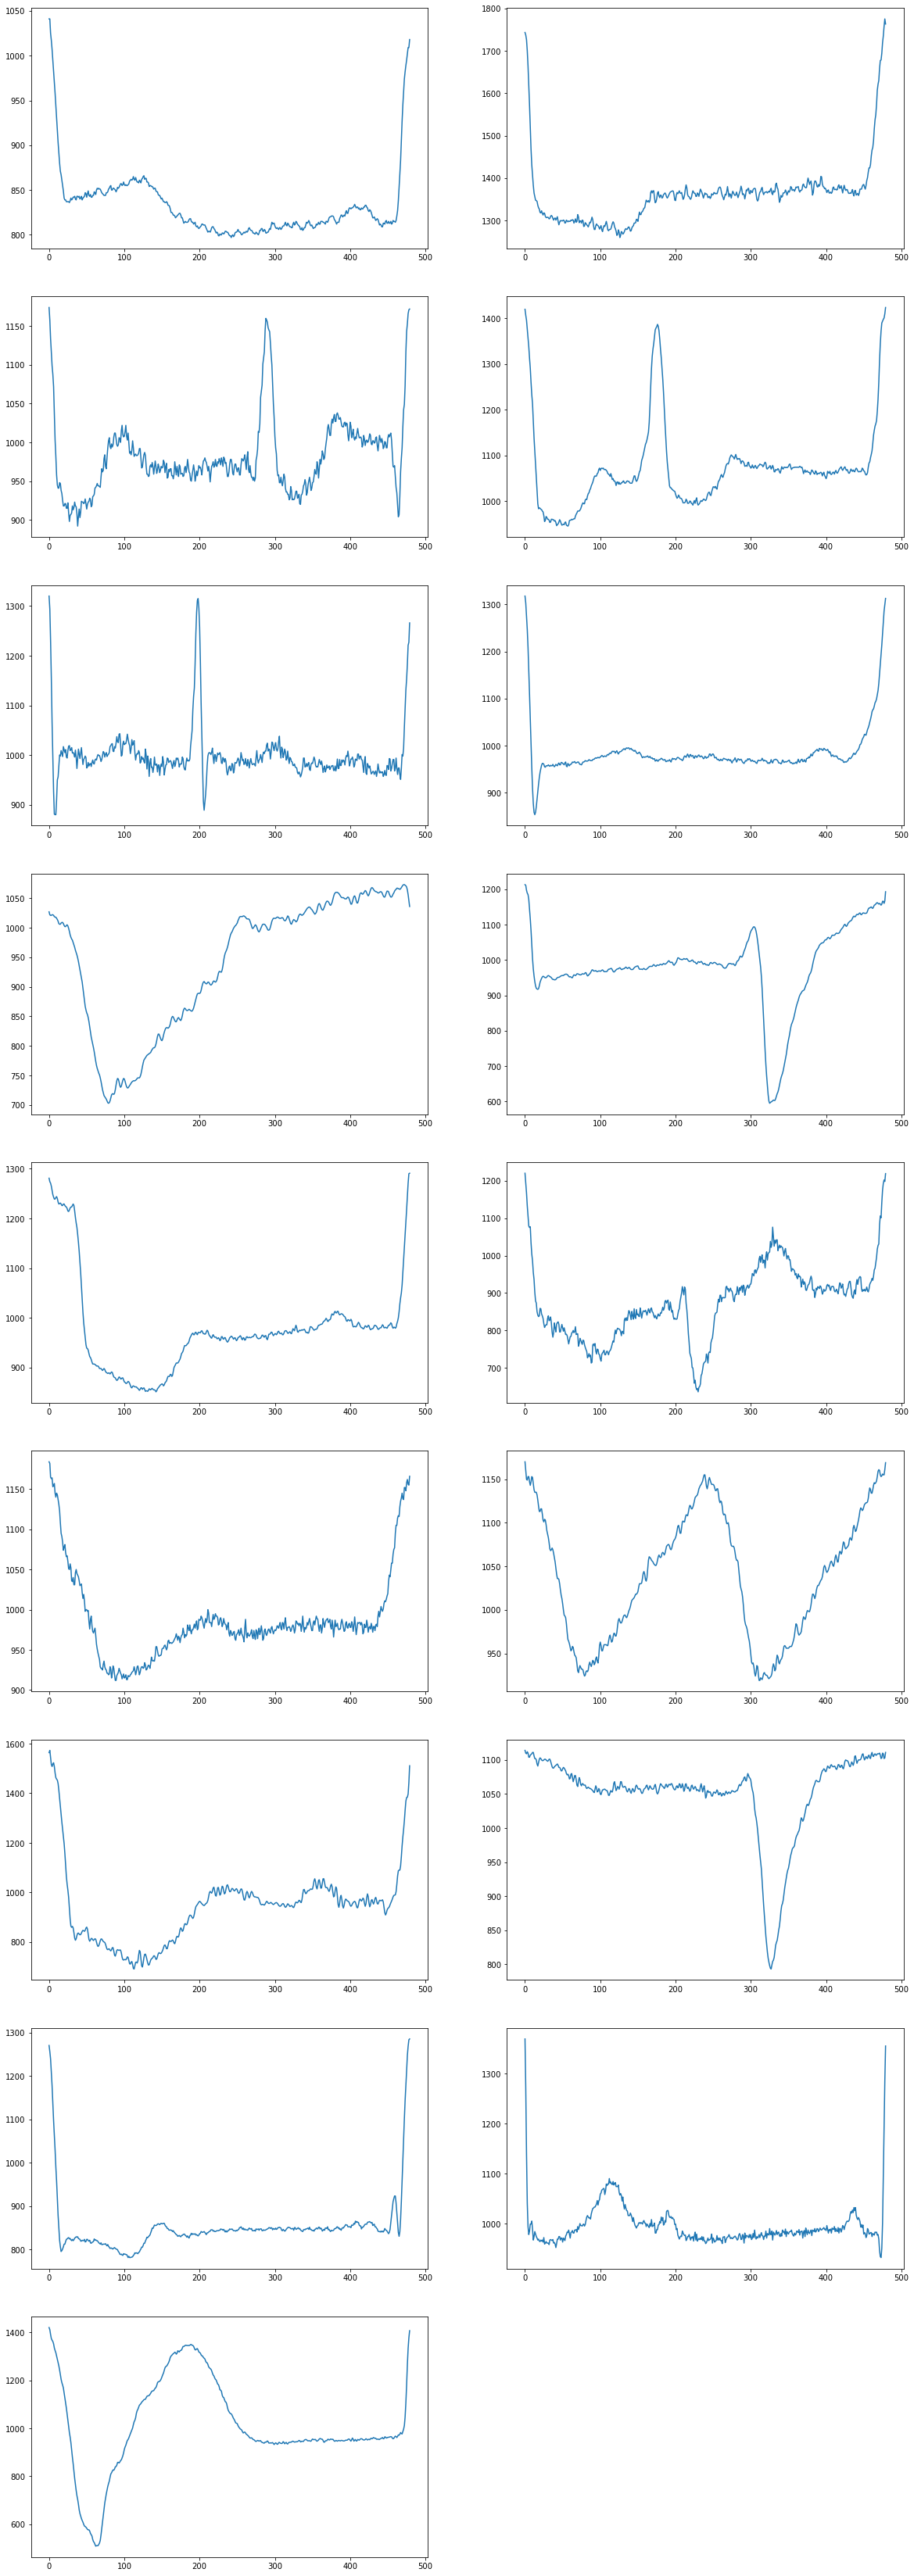

In [35]:
plt.figure(figsize=(20,60))
for i in range (1,18) :
    plt.subplot(9,2,i)
    plt.plot(vars()['ecg_aug'+str(i)+str(methd)][0,:-1])